In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo.solvers import LstsqL2

In [2]:
model=nengo.Network()
with model:
    CS = nengo.Node(lambda t: (signal.square(2*np.pi*0.5*t)+1)/2 + np.random.randn(1)/50*(signal.square(2*np.pi*0.5*t)+1)/2)
    C = nengo.Ensemble(n_neurons=100, dimensions=1)
    LA = nengo.Ensemble(n_neurons=100, dimensions=1)
    nengo.Connection(CS, C)
    
    # When connecting pre to post,
    # create the connection such that initially it will
    # always output 0. Usually this results in connection
    # weights that are also all 0.
    conn = nengo.Connection(C, LA, function=lambda x: x if x<0.4 else [0], learning_rule_type=nengo.PES(learning_rate=2e-4))    
    
    # Calculate the error signal with another ensemble
    error = nengo.Ensemble(100, dimensions=1)
    out_err = nengo.Ensemble(100, dimensions=1)

    # Error = actual-target = LA_decoded - C_decoded
    
    nengo.Connection(LA, error)
    nengo.Connection(C, error, transform=-1)

    # Connect the error into the learning rule
    nengo.Connection(error, conn.learning_rule, transform=1)
    
    # when you want get the value of (C-LA)
    nengo.Connection(error, out_err, transform=-1)

    CS_p = nengo.Probe(CS)
    C_p = nengo.Probe(C, synapse=0.01)
    LA_p = nengo.Probe(LA, synapse=0.01)
    error_p = nengo.Probe(out_err, synapse=0.01)

In [3]:
with nengo.Simulator(model) as sim:
    sim.run(10)
t = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

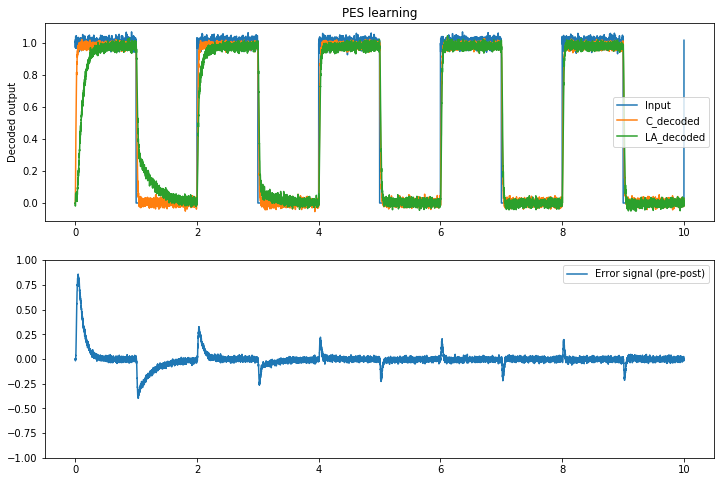

In [5]:
def plot_decoded(t, data):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.title('PES learning', loc='center')
    plt.plot(t, data[CS_p], label='Input')
    plt.plot(t, data[C_p], label='C_decoded')
    plt.plot(t, data[LA_p], label='LA_decoded')
    plt.ylabel("Decoded output")
    plt.legend(loc='best')
    plt.subplot(2, 1, 2)
    plt.plot(t, data[error_p])
    plt.ylim(-1, 1)
    plt.legend(("Error signal (pre-post)",), loc='best')


plot_decoded(t, sim.data)